# Helpfulness Prediction
## Data Science and Big Data Analytics Project

---

### Authors: 
- **Andrea Alberti** ([GitHub](https://github.com/AndreaAlberti07))
- **Davide Ligari** ([GitHub](https://github.com/DavideLigari01))
- **Cristian Andreoli** ([GitHub](https://github.com/CristianAndreoli94))

### Date: September 2023

---

## Data: 
The chosen dataset is [Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews).


## Goal:
Build a model able to predict the helpfulness of a review based on its content. 

---

In [2]:
import pymongo as pm
import pyspark as ps
import pandas as pd
import numpy as np
import gensim
import sklearn as sk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestRegressor
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaalberti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Data Loading

In [3]:
client = pm.MongoClient('mongodb://localhost:27017/')
spark_db = client['spark_db']
books_ratings = spark_db['books_rating']

### 2. Data Reshaping

In [4]:
pipeline_remove = {'$match':{
                        'review/score':{'$exists':True},
                        'N_helpful'	:{'$exists':True, '$ne':0},
                        'Tot_votes'	:{'$exists':True, '$ne':0}
                        }
    
                }

smoothing_param = 1

pipeline_project = {'$project':{
                            'review/text':1,
                            'helpfulness_score':{'$divide':[
                                                        {'$sum':['$N_helpful', smoothing_param]},
                                                        {'$sum': ['$Tot_votes', smoothing_param*2]}
                                                             ]
                                                 },
                            '_id':0,
                            }
                    }

mongo_dataset = books_ratings.aggregate([pipeline_remove, pipeline_project])
df_dataset = pd.DataFrame(list(mongo_dataset))
arr_dataset = np.array(df_dataset)

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(arr_dataset[:,0], arr_dataset[:,1], test_size=0.2, random_state=42)

### 3. Features Extraction

In [5]:
stop_words = set(stopwords.words('english'))

def preprocess(doc):
    tokens = gensim.utils.simple_preprocess(doc)
    return [token for token in tokens if token not in stop_words]

X_train_w2v = [preprocess(doc) for doc in X_train]

In [6]:
model = gensim.models.Word2Vec(X_train_w2v, vector_size=30, window=5, min_count=2)

def get_embedding(doc):
    embeddings = []
    words = preprocess(doc)
    for word in words:
        if word in model.wv:
            embeddings.append(model.wv[word])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

X_train_embedding = [get_embedding(doc) for doc in X_train]
X_test_embedding = [get_embedding(doc) for doc in X_test]

In [ ]:
np.savez('../model/train_data_wv2_30_5.npz',x = X_train_embedding, y = Y_train)
np.savez('../model/test_data_w2v_30_5.npz',x = X_test_embedding, y = Y_test)

### 4. Model Training

In [ ]:
rand_forest = RandomForestRegressor(n_estimators=100, random_state=42)
rand_forest.fit(X_train_embedding, Y_train)
joblib.dump(rand_forest, '../model/rand_forest_model.gz', compress=('gzip', 3))

In [ ]:
Y_pred_smoothing = rand_forest.predict(X_test_embedding)

In [ ]:
def rmse(Y_test, Y_pred):
    return np.sqrt(sk.metrics.mean_squared_error(Y_test, Y_pred))

rmse_smoothing = rmse(Y_test, Y_pred_smoothing)
print('RMSE with smoothing: ', rmse_smoothing)

# Choose a dynamic threshold to determine whether a review is helpful or not

### 5. Model Evaluation

In [9]:
train_data = np.load('../model/_gitignore/train_data_wv2_30_5.npz', allow_pickle=True)
test_data = np.load('../model/_gitignore/test_data_w2v_30_5.npz', allow_pickle=True)

X_train = train_data['x']
Y_train = train_data['y']
X_test = test_data['x']
Y_test = test_data['y']

rand_forest = joblib.load('../model/_gitignore/rand_forest_model.gz')

Y_test_pred = rand_forest.predict(X_test)
Y_train_pred = rand_forest.predict(X_train)

def rmse(Y_test, Y_pred):
    return np.sqrt(sk.metrics.mean_squared_error(Y_test, Y_pred))

print('RMSE on train data: ', rmse(Y_train, Y_train_pred))
print('RMSE on test data: ', rmse(Y_test, Y_test_pred))

# The model tends to overfit the data

RMSE on train data:  0.05885472010068144
RMSE on test data:  0.1558607170520689


In [ ]:
# Other approach: change the helpfulness before, and just fit a binary classification model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def equation(c, x, y):
    return (x + c) / (y + 2 * c)

def find_xy_pairs(c, target_ratio, rmse, max_value=100):
    valid_pairs = []
    upper_pairs = []
    lower_pairs = []

    for x in range(1, max_value + 1):
        for y in range(1, max_value + 1):
            if (
                equation(c, x, y) >= target_ratio * 0.99
                and equation(c, x, y) <= target_ratio * 1.01
            ):
                valid_pairs.append((x, y))
            if (
                equation(c, x, y) >= (target_ratio+rmse) * 0.99
                and equation(c, x, y) <= (target_ratio+rmse) * 1.01
            ):
                upper_pairs.append((x, y))
            if (
                equation(c, x, y) >= (target_ratio-rmse) * 0.99
                and equation(c, x, y) <= (target_ratio-rmse) * 1.01
            ):
                lower_pairs.append((x, y))

    return valid_pairs, upper_pairs, lower_pairs

c = 5  # Replace with your desired constant value
target_ratio = 0.8  # Replace with your desired target ratio
max_value = 100  # You can adjust this maximum value as needed

valid_pairs, upper_pairs, lower_pairs = find_xy_pairs(c, target_ratio, 0.05885472010068144, max_value)

x_values_valid = [x for x, _ in valid_pairs]
y_values_valid = [y for _, y in valid_pairs]
x_values_upper = [x for x, _ in upper_pairs]
y_values_upper = [y for _, y in upper_pairs]
x_values_lower = [x for x, _ in lower_pairs]
y_values_lower = [y for _, y in lower_pairs]

plt.plot(y_values_valid, x_values_valid, label=f"(x, y) for ~{target_ratio}", color='blue')
plt.plot(y_values_upper, x_values_upper, label=f"(x, y) for ~{target_ratio}+rmse", color='red')
plt.plot(y_values_lower, x_values_lower, label=f"(x, y) for ~{target_ratio}-rmse", color='green')
plt.ylim(0, max_value)
plt.xlim(0, max_value)
plt.xlabel("Total votes")
plt.ylabel("Number is_helpful votes")
plt.title(f"Pairs of (x, y) for (x+c)/(y+2c) ~ {target_ratio} (c = {c})")
plt.grid(True)
plt.legend()
plt.show()



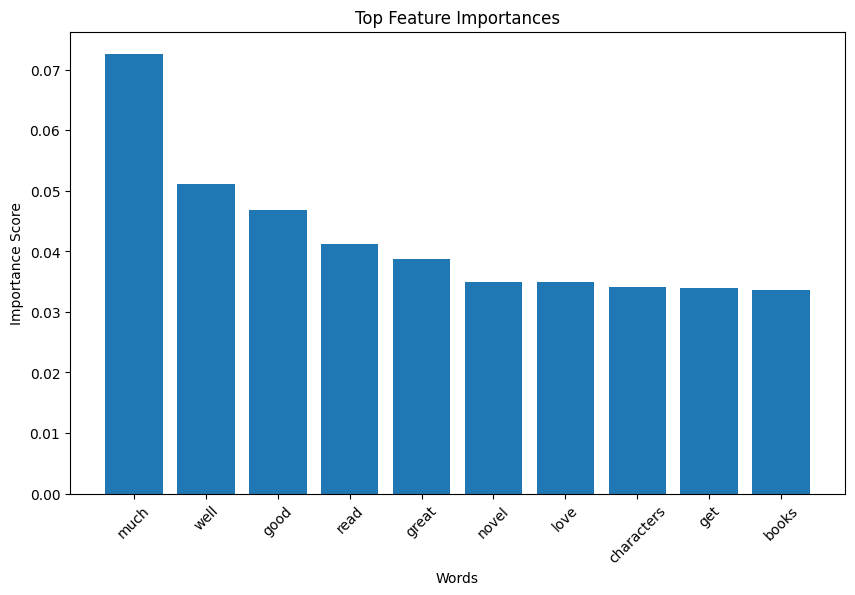

In [16]:
import matplotlib.pyplot as plt

# Get the feature importances from the trained model
feature_importances = rand_forest.feature_importances_

# Sort the feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Get the top N most important words
top_N = 10  # Change this to the desired number of top words
top_words = [model.wv.index_to_key[idx] for idx in sorted_idx[:top_N]]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(top_N), feature_importances[sorted_idx[:top_N]])
plt.xticks(range(top_N), top_words, rotation=45)
plt.title("Top Feature Importances")
plt.xlabel("Words")
plt.ylabel("Importance Score")
plt.show()


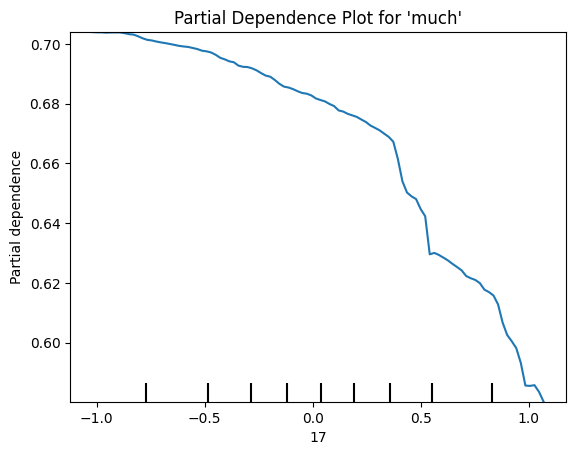

In [31]:
from sklearn.inspection import plot_partial_dependence

# Assuming 'X' is your feature matrix (Word2Vec representation)
# and 'rf_model' is your trained Random Forest model
word_idx = model.wv.key_to_index['much']

# Create a PDP for the specific word
plot_partial_dependence(rand_forest, X_train, features=[word_idx], grid_resolution=100)
plt.title("Partial Dependence Plot for 'much'")
plt.show()


---

## Use Total votes as feature to predict helpful votes

In [ ]:
pipeline_remove = {'$match':{
                        'review/score':{'$exists':True},
                        'N_helpful'	:{'$exists':True, '$ne':0},
                        'Tot_votes'	:{'$exists':True, '$ne':0}
                        }
    
                }

smoothing_param = 1

pipeline_project = {'$project':{
                            'review/text':1,
                            'Tot_votes':1,
                            'N_helpful':1,
                            '_id':0,
                            }
                    }

mongo_dataset = books_ratings.aggregate([pipeline_remove, pipeline_project])
df_dataset = pd.DataFrame(list(mongo_dataset))
arr_dataset = np.array(df_dataset)

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(arr_dataset[:,0:2], arr_dataset[:,2], test_size=0.2, random_state=42)

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(doc):
    tokens = gensim.utils.simple_preprocess(doc)
    return [token for token in tokens if token not in stop_words]

X_train_w2v = [preprocess(doc[0]) for doc in X_train[:]]

In [ ]:
model = gensim.models.Word2Vec(X_train_w2v, vector_size=30, window=5, min_count=2)

def get_embedding(doc):
    embeddings = []
    words = preprocess(doc[0])
    for word in words:
        if word in model.wv:
            embeddings.append(np.append(model.wv[word], doc[1]))
    if len(embeddings) > 0:
         return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size+1)

X_train_embedding = [get_embedding(doc) for doc in X_train[:]]
X_test_embedding = [get_embedding(doc) for doc in X_test[:]]

In [ ]:
np.savez('../model/train_data_wv2_totvotes_30_5.npz',x = X_train_embedding, y = Y_train)
np.savez('../model/test_data_w2v_totvotes_30_5.npz',x = X_test_embedding, y = Y_test)

In [ ]:
rand_forest = RandomForestRegressor(n_estimators=100, random_state=42)
rand_forest.fit(X_train_embedding, Y_train)
joblib.dump(rand_forest, '../model/rand_forest_model_totvotes.gz', compress=('gzip', 3))

In [ ]:
Y_test_pred = rand_forest.predict(X_test_embedding)
Y_train_pred = rand_forest.predict(X_train_embedding)

In [ ]:
def rmse(Y_test, Y_pred):
    return np.sqrt(sk.metrics.mean_squared_error(Y_test, Y_pred))

rmse_test = rmse(Y_test, Y_test_pred)
print('RMSE with smoothing: ', rmse_test)

rmse_train = rmse(Y_train, Y_train_pred)
print('RMSE with smoothing: ', rmse_train)